## <font color=purple>Import needed modules</font>

In [1]:
#!pip install scikit-learn-intelex

In [2]:
#NEW
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
#general libraries needed
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

#scikit learn imports
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

#give yourself the opportunity to visualize the pipeline and models
from sklearn import set_config
set_config(display='diagram')

## <font color=purple>Function Definitions

In [4]:
#function to verify the existence of a file in the current working directory and download it if not
import os,urllib, urllib.request, sys, tarfile
def downloadDataResource(file,sourcePath,compressed=None):
    if not os.path.isfile(file):
        try:
            urllib.request.urlretrieve(sourcePath+(compressed if compressed else file),(compressed if compressed else file))
            print("Downloaded", (compressed if compressed else file) )
            if compressed:
                ucomp = tarfile.open(compressed)
                ucomp.extractall()
                ucomp.close()
                print("File uncompressed.")
        except:
            print("ERROR: File", (compressed if compressed else file), "not found. Data source missing.")
    else:
        print("Data resource", file, "already downloaded.")

In [5]:
#function that shows a learning curve for any model that has predict or fit methods
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator,X,y,ylim=None,cv=None,n_jobs=None,train_sizes=np.linspace(0.1, 1.0, 20),scoring = 'neg_root_mean_squared_error'):
    
    _, axes = plt.subplots(1, 1, figsize=(10, 5))    
    axes.set_title('Learning Curve')
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel(scoring)

    train_sizes, train_scores, test_scores= learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes,scoring = scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes,train_scores_mean - train_scores_std,train_scores_mean + train_scores_std,alpha=0.1,color="r")
    axes.fill_between(train_sizes,test_scores_mean - test_scores_std,test_scores_mean + test_scores_std,alpha=0.1,color="g")
    axes.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")
    axes.legend(loc="best")
    plt.show()
    
    return

#code to prevent warnings that can occur as a result of this function
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

## <font color=purple>Source Data

In [6]:
#download data files if not currently downloaded into the current working directory
path = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename = "sephora_website_dataset.csv"


path2 = "https://raw.githubusercontent.com/sarahwhynott/Machine-Learning/main/"
filename2 = "product_info.csv"


downloadDataResource(filename, path)
downloadDataResource(filename2, path2)

Data resource sephora_website_dataset.csv already downloaded.
Data resource product_info.csv already downloaded.


In [7]:
#create a dataframe with the data from the CSV file
df = pd.read_csv(filename)
df2 = pd.read_csv(filename2)

## <font color=purple>Analyze the data set

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  details                 9168 non-null   

In [9]:
df.describe()

,id,rating,number_of_reviews,love,price,value_price,online_only,exclusive,limited_edition,limited_time_offer
count,9.168000e+03,9168.000000,9168.000000,9.168000e+03,9168.000000,9168.00000,9168.000000,9168.000000,9168.000000,9168.000000
mean,1.962952e+06,3.990020,282.139180,1.627859e+04,50.063237,51.82359,0.234839,0.264725,0.091841,0.000327
std,3.859714e+05,1.007707,890.642028,4.260651e+04,47.164989,49.45902,0.423921,0.441211,0.288817,0.018087
min,5.000000e+01,0.000000,0.000000,0.000000e+00,2.000000,2.00000,0.000000,0.000000,0.000000,0.000000
25%,1.819453e+06,4.000000,10.000000,1.600000e+03,24.000000,25.00000,0.000000,0.000000,0.000000,0.000000
50%,2.072354e+06,4.000000,46.000000,4.800000e+03,35.000000,35.00000,0.000000,0.000000,0.000000,0.000000
75%,2.230591e+06,4.500000,210.000000,1.380000e+04,59.000000,60.00000,0.000000,1.000000,0.000000,0.000000
max,2.359685e+06,5.000000,19000.000000,1.300000e+06,549.000000,549.00000,1.000000,1.000000,1.000000,1.000000


In [10]:
df.corr()

,id,rating,number_of_reviews,love,price,value_price,MarketingFlags,online_only,exclusive,limited_edition,limited_time_offer
id,1.000000,-0.176684,-0.175482,-0.104208,-0.026661,-0.004168,0.283722,0.153745,0.199285,0.200357,-0.008607
rating,-0.176684,1.000000,0.081478,0.094788,0.019559,0.001941,-0.108410,-0.123342,-0.001908,-0.130471,0.006164
number_of_reviews,-0.175482,0.081478,1.000000,0.746099,-0.084001,-0.088855,-0.096984,-0.137082,0.003799,-0.066661,0.000742
love,-0.104208,0.094788,0.746099,1.000000,-0.088724,-0.091140,-0.057228,-0.138933,0.050957,-0.046750,-0.002879
price,-0.026661,0.019559,-0.084001,-0.088724,1.000000,0.983357,-0.056920,0.117250,-0.178809,0.015333,-0.009679
value_price,-0.004168,0.001941,-0.088855,-0.091140,0.983357,1.000000,-0.028660,0.130658,-0.159005,0.079754,-0.009874
MarketingFlags,0.283722,-0.108410,-0.096984,-0.057228,-0.056920,-0.028660,1.000000,0.578973,0.627080,0.332344,0.018908
online_only,0.153745,-0.123342,-0.137082,-0.138933,0.117250,0.130658,0.578973,1.000000,-0.077543,0.097353,-0.010023
exclusive,0.199285,-0.001908,0.003799,0.050957,-0.178809,-0.159005,0.627080,-0.077543,1.000000,0.166162,0.002814
limited_edition,0.200357,-0.130471,-0.066661,-0.046750,0.015333,0.079754,0.332344,0.097353,0.166162,1.000000,0.015129


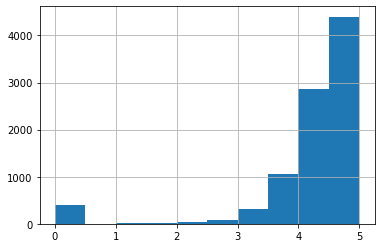

In [11]:
df["rating"].hist()
plt.show()

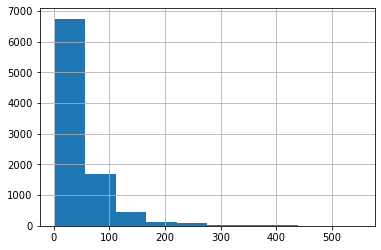

In [12]:
df["price"].hist()
plt.show()

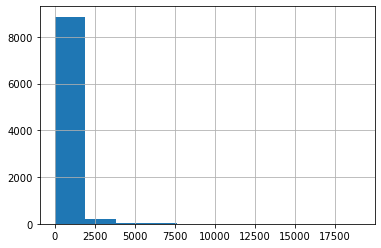

In [13]:
df["number_of_reviews"].hist()
plt.show()

## <font color=purple>Transform Data

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9168 entries, 0 to 9167
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9168 non-null   int64  
 1   brand                   9168 non-null   object 
 2   category                9168 non-null   object 
 3   name                    9168 non-null   object 
 4   size                    9168 non-null   object 
 5   rating                  9168 non-null   float64
 6   number_of_reviews       9168 non-null   int64  
 7   love                    9168 non-null   int64  
 8   price                   9168 non-null   float64
 9   value_price             9168 non-null   float64
 10  URL                     9168 non-null   object 
 11  MarketingFlags          9168 non-null   bool   
 12  MarketingFlags_content  9168 non-null   object 
 13  options                 9168 non-null   object 
 14  details                 9168 non-null   

In [15]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8494 entries, 0 to 8493
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   product_id          8494 non-null   object 
 1   product_name        8494 non-null   object 
 2   brand_id            8494 non-null   int64  
 3   brand_name          8494 non-null   object 
 4   loves_count         8494 non-null   int64  
 5   rating              8216 non-null   float64
 6   reviews             8216 non-null   float64
 7   size                6863 non-null   object 
 8   variation_type      7050 non-null   object 
 9   variation_value     6896 non-null   object 
 10  variation_desc      1250 non-null   object 
 11  ingredients         7549 non-null   object 
 12  price_usd           8494 non-null   float64
 13  value_price_usd     451 non-null    float64
 14  sale_price_usd      270 non-null    float64
 15  limited_edition     8494 non-null   int64  
 16  new   

In [16]:
df2.rename(columns = {'product_name':'name'}, inplace = True)
#df2.rename(columns = {'rating':'2023ratings'}, inplace = True)

In [17]:
df["cat_rating"] = ["3.5" if x < 4.0 else "4.0" if x == 4.0 else "4.5" if x == 4.5 else "5" for x in df["rating"]]

In [18]:
df = pd.merge(df,df2[['name',"secondary_category"]],on='name', how='left')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9232 entries, 0 to 9231
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      9232 non-null   int64  
 1   brand                   9232 non-null   object 
 2   category                9232 non-null   object 
 3   name                    9232 non-null   object 
 4   size                    9232 non-null   object 
 5   rating                  9232 non-null   float64
 6   number_of_reviews       9232 non-null   int64  
 7   love                    9232 non-null   int64  
 8   price                   9232 non-null   float64
 9   value_price             9232 non-null   float64
 10  URL                     9232 non-null   object 
 11  MarketingFlags          9232 non-null   bool   
 12  MarketingFlags_content  9232 non-null   object 
 13  options                 9232 non-null   object 
 14  details                 9232 non-null   

In [20]:
df.head()

,id,brand,category,name,size,rating,number_of_reviews,love,price,value_price,...,options,details,how_to_use,ingredients,online_only,exclusive,limited_edition,limited_time_offer,cat_rating,secondary_category
0,2218774,Acqua Di Parma,Fragrance,Blu Mediterraneo MINIATURE Set,5 x 0.16oz/5mL,4.0,4,3002,66.0,75.0,...,no options,This enchanting set comes in a specially handc...,Suggested Usage:-Fragrance is intensified by t...,Arancia di Capri Eau de Toilette: Alcohol Dena...,1,0,0,0,4.0,NaN
1,2044816,Acqua Di Parma,Cologne,Colonia,0.7 oz/ 20 mL,4.5,76,2700,66.0,66.0,...,- 0.7 oz/ 20 mL Spray - 1.7 oz/ 50 mL Eau d...,An elegant timeless scent filled with a fresh-...,no instructions,unknown,1,0,0,0,4.5,Men
2,1417567,Acqua Di Parma,Perfume,Arancia di Capri,5 oz/ 148 mL,4.5,26,2600,180.0,180.0,...,- 1oz/30mL Eau de Toilette - 2.5 oz/ 74 mL E...,Fragrance Family: Fresh Scent Type: Fresh Citr...,no instructions,Alcohol Denat.- Water- Fragrance- Limonene- Li...,1,0,0,0,4.5,Women
3,1417617,Acqua Di Parma,Perfume,Mirto di Panarea,2.5 oz/ 74 mL,4.5,23,2900,120.0,120.0,...,- 1 oz/ 30 mL Eau de Toilette Spray - 2.5 oz/...,Panarea near Sicily is an an island suspended ...,no instructions,unknown,1,0,0,0,4.5,Women
4,2218766,Acqua Di Parma,Fragrance,Colonia Miniature Set,5 x 0.16oz/5mL,3.5,2,943,72.0,80.0,...,no options,The Colonia Miniature Set comes in an iconic A...,Suggested Usage:-Fragrance is intensified by t...,Colonia: Alcohol Denat.- Water- Fragrance- Lim...,1,0,0,0,3.5,NaN


In [21]:
df.name.str.split().explode().value_counts().head(10)

Mini     665
&        629
Cream    530
Set      464
Lip      404
Mask     402
de       400
Eau      400
Brush    393
Oil      387
Name: name, dtype: int64

In [22]:
df["mini"] = [1 if "Mini" in x else 0 for x in df["name"]]
df["cream"] = [1 if "Cream" in x else 0 for x in df["name"]]
df["set"] = [1 if "Set" in x else 0 for x in df["name"]]
df["mask"] = [1 if "Mask" in x else 0 for x in df["name"]]
df["eau"] = [1 if "Eau" in x else 0 for x in df["name"]]
df["lip"] = [1 if "Lip" in x else 0 for x in df["name"]]
df["brush"] = [1 if "Brush" in x else 0 for x in df["name"]]
df["oil"] = [1 if "Oil" in x else 0 for x in df["name"]]

In [23]:
df.ingredients.str.split().explode().value_counts().head(20)

Extract-         17337
the              17179
that             14600
of               14080
and              13214
Oil-             12294
Sodium           11416
(Ci              11147
-                10386
to               10238
Glycol-           7869
Acid-             7759
Seed              7295
or                7005
are               6973
is                6933
methacrylate-     6591
Ci                5710
be                5522
products          5429
Name: ingredients, dtype: int64

In [24]:
df["extract"] = [1 if "Extract-" in x else 0 for x in df["ingredients"]]
df["oil"] = [1 if "Oil- " in x else 0 for x in df["ingredients"]]
df["sodium"] = [1 if "Sodium" in x else 0 for x in df["ingredients"]]
df["glycol"] = [1 if "Glycol-" in x else 0 for x in df["ingredients"]]
df["acid"] = [1 if "Acid-" in x else 0 for x in df["ingredients"]]
df["seed"] = [1 if "Seed" in x else 0 for x in df["ingredients"]]
df["metha"] = [1 if "methacrylate- " in x else 0 for x in df["ingredients"]]

In [25]:
toPredict = df.loc[(df['name'] == 'Green Clean Makeup Removing Cleansing Balm') 
                   | (df['name'] == 'Glowscreen Sunscreen SPF 40')
                  | (df['name'] == 'Wisteria & Lavender Cologne')]

In [26]:
df = df[df.name != 'Green Clean Makeup Removing Cleansing Balm']
df = df[df.name != 'Glowscreen Sunscreen SPF 40']
df = df[df.name != 'Wisteria & Lavender Cologne']

In [27]:
df = df.drop(columns = ["id","rating","name","size","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients"])

In [28]:
toPredict=toPredict.drop(columns=["id","rating","name","size","value_price","URL","MarketingFlags","MarketingFlags_content","options","details","how_to_use","ingredients"])

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9229 entries, 0 to 9231
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   brand               9229 non-null   object 
 1   category            9229 non-null   object 
 2   number_of_reviews   9229 non-null   int64  
 3   love                9229 non-null   int64  
 4   price               9229 non-null   float64
 5   online_only         9229 non-null   int64  
 6   exclusive           9229 non-null   int64  
 7   limited_edition     9229 non-null   int64  
 8   limited_time_offer  9229 non-null   int64  
 9   cat_rating          9229 non-null   object 
 10  secondary_category  2467 non-null   object 
 11  mini                9229 non-null   int64  
 12  cream               9229 non-null   int64  
 13  set                 9229 non-null   int64  
 14  mask                9229 non-null   int64  
 15  eau                 9229 non-null   int64  
 16  lip   

##  <font color=purple>  Baseline Performance

In [30]:
df.cat_rating.value_counts(normalize = True)

4.5    0.384657
4.0    0.311626
3.5    0.208690
5      0.095027
Name: cat_rating, dtype: float64

### Create Training and Test data sets

In [31]:
X_train_pre, X_test_pre, y_train, y_test = train_test_split(
    df.drop(columns=['cat_rating']),
    df['cat_rating'],
    test_size=0.2,
    random_state=34
)    
X_train_pre.shape,X_test_pre.shape,y_train.shape, y_test.shape 

((7383, 24), (1846, 24), (7383,), (1846,))

### Prepare Data

In [32]:
cat_attribs = ["brand", "category","secondary_category"]

#set the numerical attributes
num_attribs = list( X_train_pre.drop(cat_attribs,axis=1) )

num_pipeline = Pipeline( [
 ('imputer', SimpleImputer(strategy="median")), #because no missing values, not used
 ('std_scaler', StandardScaler()),   
])

#define the column transformation process for the data set
full_pipeline = ColumnTransformer( [
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(sparse = False), cat_attribs)      #because no categorical attributes, not used 
])

In [33]:
#diagram pipeline process (NOTE this only works because of the import and set statement at the top)
full_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['number_of_reviews', 'love', 'price',
                                  'online_only', 'exclusive', 'limited_edition',
                                  'limited_time_offer', 'mini', 'cream', 'set',
                                  'mask', 'eau', 'lip', 'brush', 'oil',
                                  'extract', 'sodium', 'glycol', 'acid', 'seed',
                                  'metha']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['brand', 'category', 'secondary_category'])])

In [34]:
full_pipeline.fit(df)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('std_scaler',
                                                  StandardScaler())]),
                                 ['number_of_reviews', 'love', 'price',
                                  'online_only', 'exclusive', 'limited_edition',
                                  'limited_time_offer', 'mini', 'cream', 'set',
                                  'mask', 'eau', 'lip', 'brush', 'oil',
                                  'extract', 'sodium', 'glycol', 'acid', 'seed',
                                  'metha']),
                                ('cat', OneHotEncoder(sparse=False),
                                 ['brand', 'category', 'secondary_category'])])

In [35]:
#create an array of prepared data based on the training data set
X_train = full_pipeline.transform( X_train_pre )
X_train.shape

(7383, 529)

In [36]:
#create an array of prepared data based on the test data set
X_test = full_pipeline.transform( X_test_pre)
X_test.shape

(1846, 529)

### Create a list of Model Features (i.e. attributes)

In [37]:
#capture a list of all the features used in the model
#helpful later when you want to analyze feature importance

#gets the order of encoded categories (if any)
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = []
if hasattr(cat_encoder, 'categories_'):
    for i in cat_encoder.categories_:
        cat_one_hot_attribs += list(i)
        
#combines the numeric and encoded features
attributes = list(num_attribs) + list(cat_one_hot_attribs)
attributes

['number_of_reviews',
 'love',
 'price',
 'online_only',
 'exclusive',
 'limited_edition',
 'limited_time_offer',
 'mini',
 'cream',
 'set',
 'mask',
 'eau',
 'lip',
 'brush',
 'oil',
 'extract',
 'sodium',
 'glycol',
 'acid',
 'seed',
 'metha',
 '8Greens',
 'AERIN',
 'ALTERNA Haircare',
 'AMOREPACIFIC',
 'Acqua Di Parma',
 'Aether Beauty',
 'Algenist',
 'Alpha-H',
 'Anastasia Beverly Hills',
 'Anthony',
 'Antonym',
 'Aquis',
 'Armani Beauty',
 'Artis',
 'Artist Couture',
 'Atelier Cologne',
 'BALENCIAGA',
 'BECCA',
 'BERDOUES',
 'BURBERRY',
 'BVLGARI',
 'Beachwaver',
 'BeautyBio',
 'Benefit Cosmetics',
 'Better Not Younger',
 'Bio Ionic',
 'Biossance',
 'Bite Beauty',
 'Black Up',
 'Blinc',
 'Bobbi Brown',
 'Briogeo',
 'Bumble and bumble',
 'Buxom',
 'By Rosie Jane',
 'Bésame Cosmetics',
 'CHANEL',
 'CLEAN RESERVE',
 'CLINIQUE',
 'COOLA',
 'COVER FX',
 'Calvin Klein',
 'Capri Blue',
 'Carolina Herrera',
 'Caudalie',
 'Cellu-cup',
 'Charlotte Tilbury',
 'Chloé',
 'Christian Louboutin',

## <font color=purple>Multinomial Classification

### Train and Evaluate Model

In [38]:
#create a linear regression model that allows for 
model=LogisticRegression()

#fit the model to the training data set
model.fit(X_train, y_train)

#calculated the accuracy (i.e. predicted vs. actual for the training data set)
acc = model.score(X_train, y_train)
print('   Accuracy: {:.2f}%'.format(acc*100))

#use cross valudation to process the data 5 different ways using linear regression model generated above
scores = cross_val_score(model, X_train, y_train, cv=5)

# look at average across all folds
print('CV Accuracy: {:.2f}%'.format( scores.mean()*100 ) )

   Accuracy: 53.89%
CV Accuracy: 44.77%


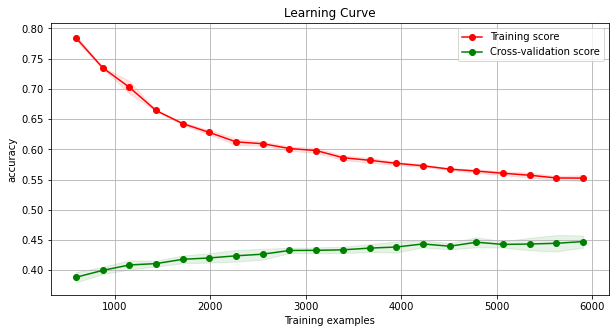

In [39]:
#plot learning curve
plot_learning_curve(model, X_train, y_train, scoring='accuracy')

### Evaluate Model on Test Set

In [40]:
#calculated the accuracy (i.e. predicted vs. actual for the test data set)
acc = model.score(X_test, y_test)
print('   Accuracy: {:.2f}%'.format(acc*100))

   Accuracy: 46.10%


In [41]:
y_pred = model.predict(X_test)
print( classification_report( y_test, y_pred) )

              precision    recall  f1-score   support

         3.5       0.40      0.33      0.36       380
         4.0       0.45      0.39      0.41       574
         4.5       0.50      0.67      0.57       712
           5       0.30      0.14      0.20       180

    accuracy                           0.46      1846
   macro avg       0.41      0.38      0.39      1846
weighted avg       0.44      0.46      0.44      1846



## <font color=purple>Try Other Classifiers</font>

In [42]:
# feel free to comment out any models you do not wish to run (particularly the decision tree & random forest regressors)
modelList = [#LogisticRegression(multi_class="multinomial", random_state=42),
             #SGDClassifier(random_state=42),
            # DecisionTreeClassifier(random_state=42), 
             #RandomForestClassifier(random_state=42),     # most time consuming so may want to skip
             #GradientBoostingClassifier(random_state=42), # also one of the most time consuming algorithms 
             HistGradientBoostingClassifier(random_state=42), 
             #KNeighborsClassifier()
            ]

for model in modelList: 

    #time how long a model needs "roughly" to learn
    print("-"*25)
    print(model)
    start_time = time.time()
    
    #fit the model to the prepared test data
    model.fit(X_train,y_train)

    #see how well the model fits
    #calculate the predicted values
    acc = model.score(X_train, y_train)
    print('   Accuracy: {:.2f}%'.format(acc*100))

    #use cross validation to process the data 5 different ways using linear regression model generated above
    scores = cross_val_score(model, X_train, y_train, cv=5)
    print('CV Accuracy: {:.2f}%'.format( scores.mean()*100 ) ) 

    print("---> {:,.2f} seconds".format(time.time() - start_time))

-------------------------
HistGradientBoostingClassifier(random_state=42)
   Accuracy: 78.59%
CV Accuracy: 49.38%
---> 279.23 seconds


## <font color=purple>Tune the Best Model</font>

In [43]:
model = HistGradientBoostingClassifier(random_state=42)

param_grid = [
    {'max_iter':[100],                   #large max_iter will take a long time
     'learning_rate': [.1, .01,.001]
    }
]

# train across 5 folds
grid_search = GridSearchCV(model, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)

#fit the data to the model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=HistGradientBoostingClassifier(random_state=42),
             param_grid=[{'learning_rate': [0.1, 0.01, 0.001],
                          'max_iter': [100]}],
             return_train_score=True, scoring='accuracy')

In [44]:
#print the RMSE results from the CV and the paramaters used during each run 
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print("CV Accuracy: {:,.2f}% - {}".format( mean_score*100, params) )

CV Accuracy: 49.38% - {'learning_rate': 0.1, 'max_iter': 100}
CV Accuracy: 49.10% - {'learning_rate': 0.01, 'max_iter': 100}
CV Accuracy: 38.51% - {'learning_rate': 0.001, 'max_iter': 100}


In [45]:
#display the best soluiton
grid_search.best_params_

{'learning_rate': 0.1, 'max_iter': 100}

### Create the Best Classifier

In [46]:
#use the parameters found above to create the model
model = HistGradientBoostingClassifier(**grid_search.best_params_)

#fit the model to the training data set
model.fit(X_train, y_train)

#compare the predicted to the actuals
acc = model.score(X_train, y_train)
print('   Accuracy: {:.2f}%'.format(acc*100))

#use cross validation to process the data 5 different ways using linear regression model generated above
scores = cross_val_score(model, X_train, y_train, cv=5)
print('CV Accuracy: {:.2f}%'.format( scores.mean()*100 ) ) 

   Accuracy: 78.59%
CV Accuracy: 49.38%


### Evaluate Best Classifier on Test Set

In [47]:
#see how well the model performs on the test data set
y_pred = model.predict(X_test)

print(" Test Accuracy: {:.2f}%".format( accuracy_score(y_test, y_pred )*100 ))

 Test Accuracy: 51.68%


# Predictions

In [50]:
X_prepared=full_pipeline.transform(toPredict)
model.predict(X_prepared)

array(['4.0', '4.0', '4.0'], dtype=object)

## <font color=purple>Add Complexity using PolynomialFeatures

In [ ]:
#try making a linear model fit data that is more likely non-linear
DEGREE = 2

#create a polynomial feature with degree based on variable DEGREE
poly_features=PolynomialFeatures(degree=DEGREE)

#transform our X by adding the square of each feature to the training set
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

X_train_poly.shape, X_test_poly.shape

In [ ]:
modelList = [LogisticRegression(random_state=42),
             #SGDClassifier(random_state=42),
            ]

for model in modelList: 

    #time how long a model needs "roughly" to learn
    print("-"*25)
    print(model)
    start_time = time.time()
    
    #fit the model to the prepared test data
    model.fit(X_train_poly,y_train)

    #compare the predicted to the actuals
    acc = model.score(X_train_poly, y_train)
    print('   Accuracy: {:.2f}%'.format(acc*100))

    #use cross validation to process the data 5 different ways using linear regression model generated above
    scores = cross_val_score(model, X_train_poly, y_train, cv=5)
    print('CV Accuracy: {:.2f}%'.format( scores.mean()*100 ) ) 

    print("---> {:,.2f} seconds".format(time.time() - start_time))

### Create the Best Poly Classifier

In [ ]:
#use the parameters found above to create the model
model_poly = LogisticRegression(multi_class="multinomial", random_state=42)

#fit the model to the training data set
model_poly.fit(X_train_poly, y_train)

#compare the predicted to the actuals
acc = model.score(X_train_poly, y_train)
print('   Accuracy: {:.2f}%'.format(acc*100))

#use cross validation to process the data 5 different ways using linear regression model generated above
scores = cross_val_score(model_poly, X_train_poly, y_train, cv=5)
print('CV Accuracy: {:.2f}%'.format( scores.mean()*100 ) ) 

In [ ]:
plot_learning_curve(model_poly, X_train_poly, y_train,scoring="accuracy")

### Evaluate Best Poly Classifier on Test Set

In [ ]:
#see how well the model performs on the test data set
y_pred = model_poly.predict(X_test_poly)

print(" Accuracy Score: {:.2f}%".format( accuracy_score(y_test, y_pred )*100 ))

In [ ]:
#NEW Classification Report of Test Data
y_pred = model.predict(X_test_poly)
print( classification_report( y_test, y_pred) )